In [2]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import gseapy as gp
import statsmodels.api as sm
from adjustText import adjust_text

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# scDRS tools
import scdrs

# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Set file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data'
DF_HOM = pd.read_csv(DATA_PATH+'/gene_annotation/mouse_human_homologs.txt', sep='\t')
DIC_MAP_H2M = {x:y for x,y in zip(DF_HOM['HUMAN_GENE_SYM'], DF_HOM['MOUSE_GENE_SYM'])}
DIC_MAP_M2H = {x:y for x,y in zip(DF_HOM['MOUSE_GENE_SYM'], DF_HOM['HUMAN_GENE_SYM'])}
DF_GS = pd.read_csv(DATA_PATH+'/gs_file/magma_10kb_top1000_zscore.74_traits.rv1.gs', sep='\t', index_col=0)
DF_TRAIT_INFO = pd.read_csv(DATA_PATH+'/supp_table.rv1/trait_info.tsv', sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/results/fig_tcell.rv1'

# Set data info
DS_LIST = ['tms_facs']
DIC_INFO = {}
DIC_INFO['tms_facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}
DIC_INFO['tms_droplet'] = {'species': 'mmusculus', 'dname': 'TMS droplet'}
DIC_INFO['ts_facs'] = {'species': 'hsapiens', 'dname': 'TS FACS'}
DIC_INFO['canogamez'] = {'species': 'hsapiens', 'dname': 'Cano-Gamez & Soskic et al.'}
DIC_INFO['nathan'] = {'species': 'hsapiens', 'dname': 'Nathan et al.'}

# Set score file
DIC_SCORE_PATH = {'tms_facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_top1000_zscore',
                  'tms_facs.tsig': DATA_PATH+'/score_file/score.tms_facs_with_cov.tcell_sig',
                 }

# Set trait list
DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST['tms_facs'] = [
    'PASS_IBD_deLange2017', 'PASS_CD_deLange2017','PASS_UC_deLange2017', 'PASS_Rheumatoid_Arthritis', 
    'PASS_Multiple_sclerosis', 'UKB_460K.disease_AID_ALL', 'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP',
    'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED', 'UKB_460K.disease_ASTHMA_DIAGNOSED', 
    'UKB_460K.disease_RESPIRATORY_ENT', 'UKB_460K.body_HEIGHTz'
]
DIC_TRAIT_LIST['tms_facs.tsig'] = [
    'naive_cd4', 'memory_cd4', 'effector_cd4', 'naive_cd8', 'memory_cd8', 'effector_cd8'
]

# Add T cell signatures to DF_TRAIT_INFO
temp_dic = {
    'naive_cd4':'Naive CD4', 'memory_cd4':'Memory CD4', 'effector_cd4':'Effector CD4',
    'naive_cd8':'Naive CD8', 'memory_cd8':'Memory CD8', 'effector_cd8':'Effector CD8'
}
for trait in temp_dic:
    DF_TRAIT_INFO.loc[trait, ['Trait_Identifier', 'Code']] = [trait, temp_dic[trait]]

### Load data 

In [4]:
# Load single-cell data 
dic_data_raw = {}
dic_data_raw['tms_facs'] = scdrs.data_loader.load_tms_ct(DATA_PATH, data_name='facs')

dic_data_proc = {}
dic_data_proc['tms_facs'] = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/single_cell_data/'
                                      'tms_proc/tcell.facs.annot.h5ad')

Trying to set attribute `.obs` of view, copying.


In [5]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = DIC_SCORE_PATH[score]+'/%s.score.gz'%trait
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)        

# Cell list to analyze
dic_cell_list = {}
for ds in DS_LIST:
    dic_cell_list[ds] = sorted(set(dic_data_proc[ds].obs_names) & set(dic_score[ds].index))

In [ ]:
# Load control score 
dic_ctrl_score = {}
for score in DIC_SCORE_PATH:
    ds = score.split('.')[0]
    dic_ctrl_score[score] = {}
    for trait in DIC_TRAIT_LIST[score]:
        file_path = DIC_SCORE_PATH[score]+'/%s.full_score.gz'%trait
        if os.path.exists(file_path):
            print('# Loading %s %s'%(score, trait))
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            dic_ctrl_score[score][trait] = temp_df.loc[dic_cell_list[ds]].copy()
        else:
            print('# missing: %s'%file_path)

# Loading tms_facs PASS_IBD_deLange2017
# Loading tms_facs PASS_CD_deLange2017


### UMAP for all T cells 

n_tissue=15, BAT,Brain_Non-Myeloid,Diaphragm,GAT,Heart,Kidney,Limb_Muscle,Liver,Lung,MAT,Marrow,SCAT,Skin,Spleen,Trachea


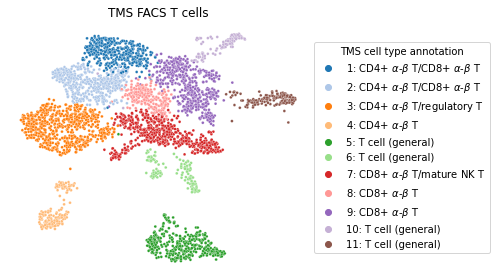

In [6]:
adata = dic_data_proc['tms_facs'].copy()
tissue_list = sorted(adata.obs['tissue'].unique())
print('n_tissue=%d, %s'%(len(tissue_list), ','.join(tissue_list)))
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]}, dtype=float)
df_plot = df_plot.join(adata.obs[['leiden_reorder', 'leiden_anno']])
df_plot['label'] = ['%s: %s'%(x,y) for x,y in zip(df_plot['leiden_reorder'], df_plot['leiden_anno'])]
df_plot['label'] = df_plot['label'].astype('category')

hue_list = []
for x in df_plot['leiden_reorder'].cat.categories:
    for y in set(df_plot['label']):
        if y.startswith('%s: '%x):
            hue_list.append(y)

plt.figure(figsize=[7,4])
ax = plt.subplot(1,1,1)
ax.axis('off')
g = sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='label', s=8, palette='tab20', hue_order=hue_list)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, title="TMS cell type annotation")
plt.title('TMS FACS T cells')
plt.tight_layout()
plt.savefig(FIG_PATH+'/tcell_tms_annot_umap.svg')
plt.show()

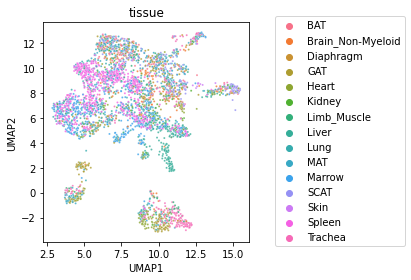

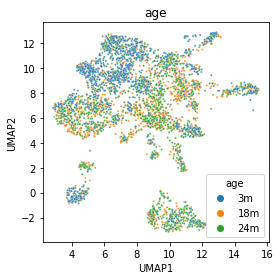

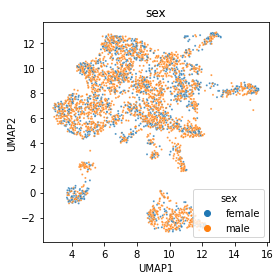

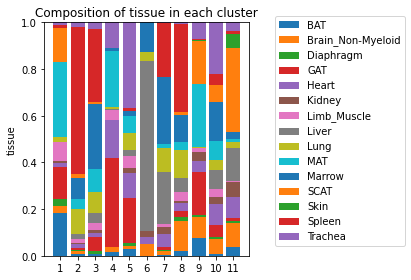

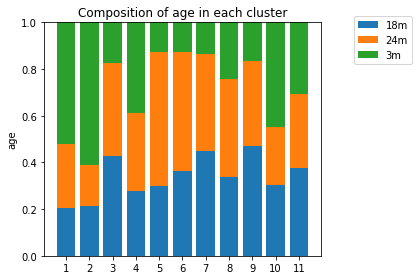

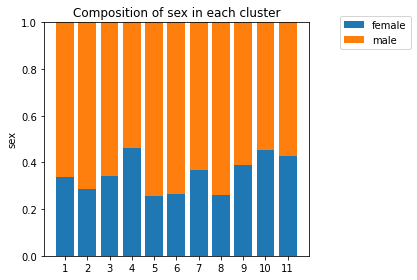

In [7]:
# FIXIT: R1
# Covariate composition UMAP
df_plot = pd.DataFrame(index=adata.obs_names, data={'UMAP1':adata.obsm['X_umap'][:,0],
                                                    'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs[['tissue', 'age', 'sex']])

for col in ['tissue', 'age', 'sex']:
    plt.figure(figsize=[4+2*(col=='tissue'),4])
    sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue=col, s=4, alpha=0.8)
    plt.title(col)
    if col=='tissue':
        plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/tcell_tms_%s.umap.svg'%col)
    plt.show()
    
# Covariate composition     
df_plot = adata.obs.copy()
df_plot['label'] = ['%s: %s'%(x,y) for x,y in zip(df_plot['leiden_reorder'], df_plot['leiden_anno'])]
df_plot['label'] = df_plot['label'].astype('category')
cluster_list = sorted(set(df_plot['leiden_reorder']))
for col in ['tissue', 'age', 'sex']:
    term_list = sorted(set(df_plot[col]))
    plt.figure(figsize=[6,4])
    v_y = np.zeros(len(cluster_list))
    for term in term_list:
        v_y_dif = np.array([(df_plot.loc[df_plot['leiden_reorder']==x, col]==term).mean() for x in cluster_list])
        plt.bar(cluster_list, v_y_dif, bottom=v_y, label=term)
        v_y = v_y+v_y_dif
    plt.xticks(cluster_list, cluster_list)
    plt.ylabel(col)
    plt.ylim([0,1])
    plt.title('Composition of %s in each cluster'%col)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/tcell_tms_%s.svg'%col)
    plt.show()

### Subpolulation of associated cells 

# IBD associated cells=387/3769


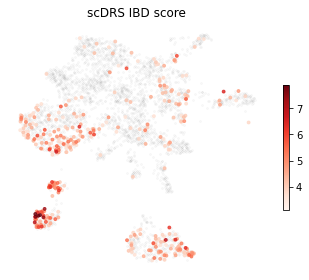

# CD associated cells=237/3769


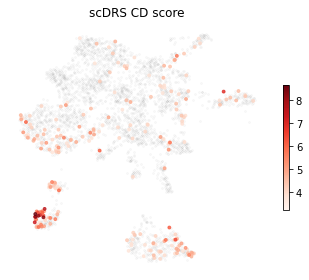

# UC associated cells=25/3769


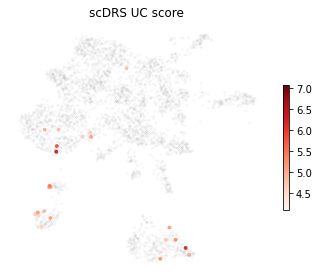

# RA associated cells=1517/3769


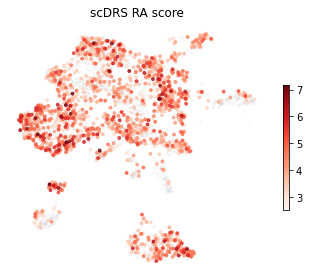

# MS associated cells=887/3769


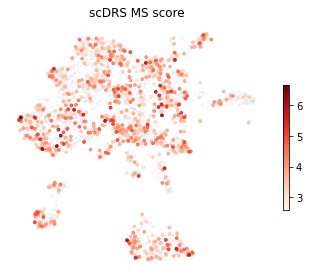

# AIT associated cells=1638/3769


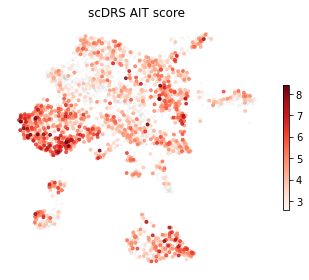

# HT associated cells=1484/3769


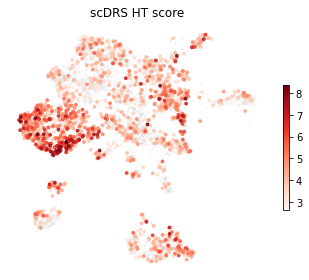

# Eczema associated cells=924/3769


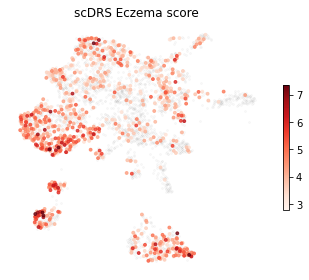

# ASM associated cells=892/3769


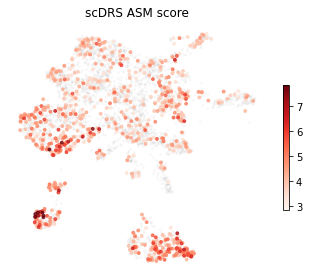

# RR-ENT associated cells=1243/3769


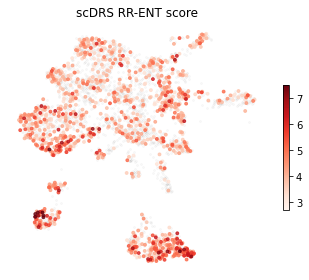

# Height associated cells=2/3769


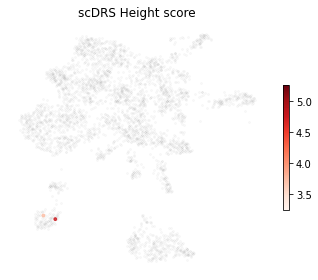

In [8]:
ds,score = 'tms_facs','tms_facs'
for trait in DIC_TRAIT_LIST[ds]:
    plt.figure(figsize=[4.8,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                           data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                                 'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1]})
    df_plot = df_plot.loc[dic_cell_list[ds]]
    df_plot = df_plot.join(dic_score[ds][['%s.fdr'%trait, '%s.norm_score'%trait]])
    df_plot.sort_values('%s.norm_score'%trait, ascending=True, inplace=True)

    ind_select = df_plot['%s.fdr'%trait]<0.1
    print('# %s associated cells=%d/%d'%(DF_TRAIT_INFO.loc[trait, 'Code'], ind_select.sum(), ind_select.shape[0]))
    vmax = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.99) + 0.5
    vmin = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.01) - 0.5
    plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                c='k', s=4, alpha=0.025)
    plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                c=df_plot.loc[ind_select, '%s.norm_score'%trait],
                cmap='Reds', s=8, vmax=vmax, vmin=vmin, alpha=0.8)
    plt.colorbar(shrink=0.5)
    plt.title('scDRS %s score'%DF_TRAIT_INFO.loc[trait, 'Code'])

    plt.tight_layout()
    plt.savefig(FIG_PATH+'/sctrs_assoc.%s.%s.svg'%(score, trait))
    plt.show()

### Annotation for PASS_IBD_deLange2017 associated cells 

# cluster 3: 123/629 significant (506 nonsig)


,cell
cell_ontology_class,
"CD4-positive, alpha-beta T cell",80.0
"CD8-positive, alpha-beta T cell",6.0
T cell,24.0
regulatory T cell,13.0


# cluster 4: 78/165 significant (87 nonsig)


,cell
cell_ontology_class,
"CD4-positive, alpha-beta T cell",28.0
"CD8-positive, alpha-beta T cell",1.0
T cell,49.0


# cluster 5: 85/370 significant (285 nonsig)


,cell
cell_ontology_class,
"CD4-positive, alpha-beta T cell",4.0
"CD8-positive, alpha-beta T cell",1.0
T cell,78.0
mature NK T cell,2.0


# cluster 9: 41/499 significant (458 nonsig)


,cell
cell_ontology_class,
"CD4-positive, alpha-beta T cell",4.0
"CD8-positive, alpha-beta T cell",24.0
T cell,13.0


... storing 'tissue_celltype' as categorical
... storing 'leiden_reorder' as categorical
... storing 'leiden_sig' as categorical
... storing 'leiden_sig_full' as categorical


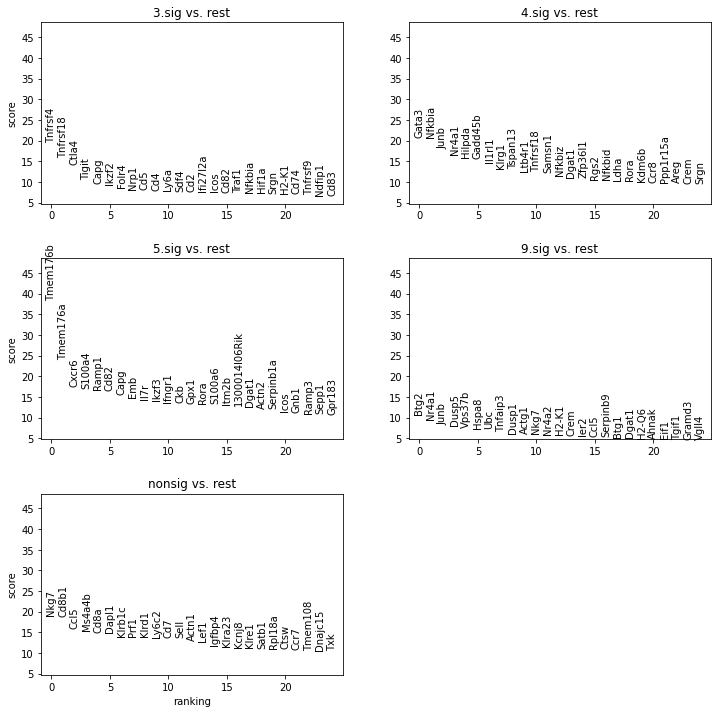

In [9]:
trait = 'PASS_IBD_deLange2017'
ds = 'tms_facs'

# Get adata 
adata = dic_data_raw[ds][dic_cell_list[ds], :].copy()
temp_adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata.obs = adata.obs.join(temp_adata.obs[[x for x in temp_adata.obs.columns if x not in adata.obs.columns]])
adata.obsm = temp_adata.obsm.copy()
adata.obs['leiden_reorder'] = [str(x) for x in adata.obs['leiden_reorder']]

# Get leiden_sig (remove sig cells in small clusters)
adata.obs = adata.obs.join(dic_score[ds]['%s.fdr'%trait])
adata.obs['leiden_sig'] = ['%s.sig'%x if y<0.1 else 'nonsig'
                           for x,y in zip(adata.obs['leiden_reorder'], adata.obs['%s.fdr'%trait])]
temp_df = adata.obs.groupby(['leiden_sig']).agg({'cell':len})
cluster_remove_list = list(temp_df.index[temp_df['cell']<25])
adata.obs['leiden_sig_full'] = adata.obs['leiden_sig'].copy()
adata.obs.loc[adata.obs['leiden_sig'].isin(cluster_remove_list), 'leiden_sig'] = 'nonsig' 

# Summarize significant cells in each cluster
group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
for group in group_list:
    print('# cluster %s: %d/%d significant (%d nonsig)'
          %(group.split('.')[0], (adata.obs['leiden_sig']==group).sum(), 
            (adata.obs['leiden_reorder']==group.split('.')[0]).sum(), 
            (adata.obs['leiden_reorder']==group.split('.')[0]).sum() - (adata.obs['leiden_sig']==group).sum()))
    temp_df = adata.obs.loc[adata.obs['leiden_sig']==group].copy()
    temp_df = temp_df.groupby('cell_ontology_class').agg({'cell':len})
    temp_df = temp_df.loc[temp_df['cell']>0]
    display(temp_df)

# Specifically expressed genes 
group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
sc.tl.rank_genes_groups(adata, groupby='leiden_sig')
sc.pl.rank_genes_groups(adata, fontsize=10, ncols=2, n_genes=25)

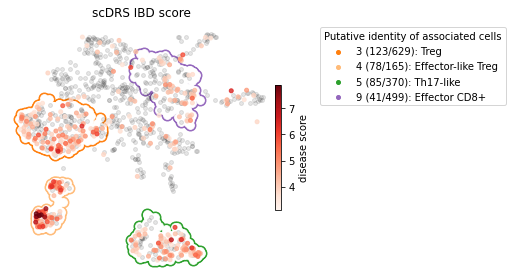

In [10]:
# UMAP plot with annotations 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
dic_config = {'3.sig': ['3 @a: Treg'], 
              # Ctla4 (Treg), Nrp1 (Treg), Tnfrsf18 (Treg), Ikzf2 (helios, Treg), Tnfrsf4 (OX40, effector)
              '4.sig': ['4 @a: Effector-like Treg'],
              # Li_CR_2019, effector Treg-like
              '5.sig': ['5 @a: Th17-like'], 
              # Cd4- Cd8-, may not be typical T cells
              '9.sig': ['9 @a: Effector CD8+']
              # Fasl (CD8+ cytotoxic T), Ifng (CD8+ cytotoxic T), Ccl5 (HIV-suppressive factor)
             }
cmap = matplotlib.cm.get_cmap('tab20')

# Get df_plot 
df_plot = pd.DataFrame(index=adata.obs_names, data={'UMAP1':adata.obsm['X_umap'][:,0],
                                                    'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs[['leiden_reorder', 'leiden_sig', 'leiden_sig_full']])
df_plot = df_plot.loc[dic_cell_list[ds]].copy()
df_plot = df_plot.join(dic_score[ds][['%s.fdr'%trait, '%s.norm_score'%trait]])
df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

# Figure 
plt.figure(figsize=[7.2,4])
ax = plt.subplot(1,1,1)
ax.axis('off')

# Cluster boundry 
x_range = df_plot['UMAP1'].max()-df_plot['UMAP1'].min()
y_range = df_plot['UMAP2'].max()-df_plot['UMAP2'].min()
for cluster in group_list:
    ind_select = df_plot['leiden_reorder']==cluster.split('.')[0]
    assoc_str = '(%d/%d)'%((ind_select&(df_plot['leiden_sig']!='nonsig')).sum(), ind_select.sum())
    temp_df = df_plot.loc[ind_select, ['UMAP1', 'UMAP2']].copy()
    xmin = np.quantile(temp_df['UMAP1'], 0.05)-0.05*x_range,
    xmax = np.quantile(temp_df['UMAP1'], 0.95)+0.05*x_range
    ymin = np.quantile(temp_df['UMAP2'], 0.05)-0.05*y_range,
    ymax = np.quantile(temp_df['UMAP2'], 0.95)+0.05*y_range
    ind_select = (temp_df['UMAP1']>xmin) & (temp_df['UMAP1']<xmax) & \
                    (temp_df['UMAP2']>ymin) & (temp_df['UMAP2']<ymax)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'][:2], temp_df.loc[ind_select, 'UMAP2'][:2],
                s=16, color=cmap(int(cluster.split('.')[0])-1),
                label=dic_config[cluster][0].replace('@a',assoc_str), zorder=0)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                s=120, color=cmap(int(cluster.split('.')[0])-1), zorder=1)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                s=60, color='w', zorder=2)

ind_select_sig = (df_plot['leiden_sig_full']!='nonsig')
np.random.seed(0)
cell_list_nonsig = np.random.choice(df_plot.index[~ind_select_sig], 
                                    size=int((~ind_select_sig).sum()*0.2), replace=False)
plt.scatter(df_plot.loc[cell_list_nonsig, 'UMAP1'], df_plot.loc[cell_list_nonsig, 'UMAP2'],
                c='k', s=16, alpha=0.1, zorder=5)

vmax = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.99) + 0.5
vmin = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.01) - 0.5
plt.scatter(df_plot.loc[ind_select_sig, 'UMAP1'], df_plot.loc[ind_select_sig, 'UMAP2'], 
            c=df_plot.loc[ind_select_sig, '%s.norm_score'%trait],
            cmap='Reds', s=16, vmax=vmax, vmin=vmin, alpha=0.8, zorder=10)
plt.colorbar(shrink=0.5, pad=0, label='disease score')
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', title='Putative identity of associated cells')
plt.title('scDRS %s score'%DF_TRAIT_INFO.loc[trait, 'Code'])
plt.tight_layout()
plt.savefig(FIG_PATH+'/sctrs_assoc.annot_IBD_umap.svg')
plt.show()

... storing 'leiden_sig_anno' as categorical


Cd3d       3.sig:477      4.sig:22820    5.sig:19323    9.sig:8924 
Cd4        3.sig:9        4.sig:16118    5.sig:21067    9.sig:4214 
Cd8a       3.sig:22964    4.sig:22963    5.sig:22964    9.sig:188  
Foxp3      3.sig:39       4.sig:228      5.sig:22910    9.sig:22932
Ctla4      3.sig:2        4.sig:405      5.sig:14738    9.sig:1445 
Lag3       3.sig:53       4.sig:21229    5.sig:22839    9.sig:8023 
Ikzf2      3.sig:5        4.sig:2827     5.sig:10107    9.sig:15416
Nrp1       3.sig:7        4.sig:13137    5.sig:431      9.sig:4445 
Folr4      3.sig:6        4.sig:20673    5.sig:22957    9.sig:16495
Tnfrsf4    3.sig:0        4.sig:264      5.sig:22716    9.sig:2133 
Tnfrsf18   3.sig:1        4.sig:10       5.sig:20381    9.sig:363  
Il1rl1     3.sig:4842     4.sig:6        5.sig:22847    9.sig:22744
Klrg1      3.sig:1425     4.sig:7        5.sig:22927    9.sig:12738
Areg       3.sig:77       4.sig:22       5.sig:8660     9.sig:13711
Gata3      3.sig:52       4.sig:0        5.sig:5

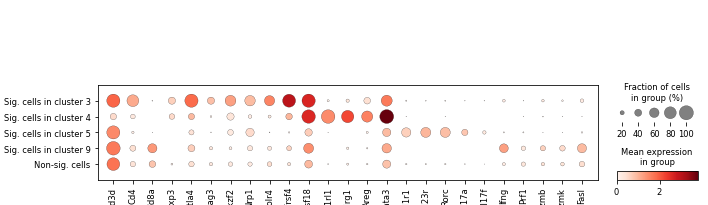

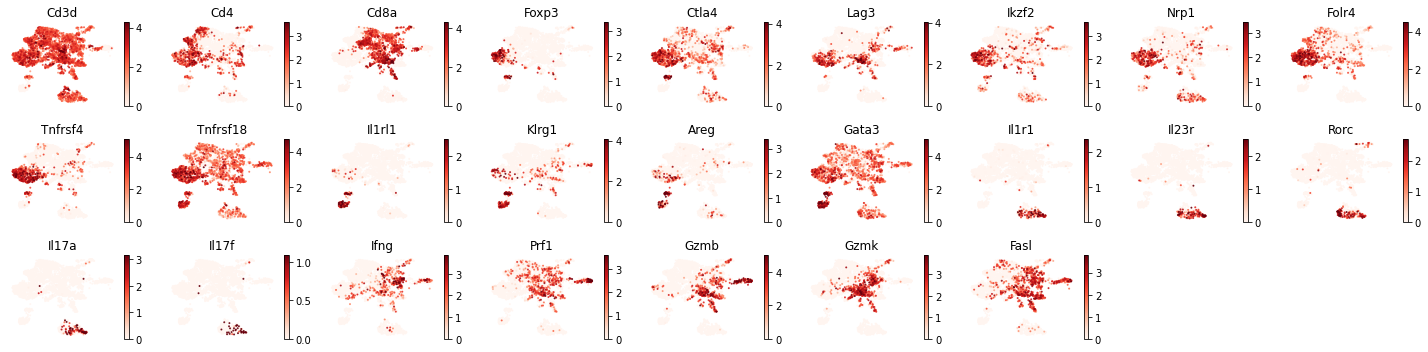

In [11]:
# Show interesting genes 
# https://www.rndsystems.com/resources/cell-markers/immune-cells/regulatory-t-cell/regulatory-t-cell-markers
gene_plot_list = ['Cd3d', 'Cd4', 'Cd8a', # T cell general
                  'Foxp3', 'Ctla4', 'Lag3', 'Ikzf2', 'Nrp1', 'Folr4', 'Tnfrsf4', 'Tnfrsf18', # Treg
                  # Foxp3: master regulator of regulatory pathway in development and function of Treg
                  # Ctla4: immune checkpoint and downregulates immune responses (T cell proliferation), 
                  # Lag3: Treg suppressive function
                  # Ikzf2 (Helios): hematopoietic-specific TF, regulation of lymphocyte development,
                      # Stable inhibitory activity of regulatory T cells requires the transcription factor Helios
                      # Kim et al Science 2015
                  # Nrp1 (Neuropilin-1): angiogenesis, axon guidance, cell survival, migration, and invasion, 
                  # Folr4 (Fr4): cell-surface marker of Tregs
                  # Tnfrsf4 (OX40): secondary co-stimulatory immune checkpoint molecule
                      # "A non‐redundant role for OX40 in the competitive fitness of Treg in response to IL‐2"
                      # Piconese EJI 2010
                  # Tnfrsf18 (Gitr): co-stimulatory immune checkpoint molecule, play a key role in dominant 
                      # immunological self-tolerance maintained by CD25+/CD4+ regulatory T cells        
                  'Il1rl1', 'Klrg1', 'Areg', 'Gata3', # KA Treg
                  # Il1rl1 (St2): enhance Treg functions 
                  # Klrg1: co-inhibitory immune checkpoint, Treg differentiation
                  # Areg: tissue repair. endogenous AREG with IL-33 decreased the intestinal inflammation in 
                      # mice with normal count of T-lymphocytes and in deficient mice
                  # Gata3: promote St2 by binding to an enhancer element Foxp3
                  'Il1r1', 'Il23r', 'Rorc', 'Il17a', 'Il17f', # Th17/Tr17
                  # Il1r1: Th17 differentiation
                  # Il23r: enhances Th17 differentiation
                  # Rorc (ROR gamma t): differentiation of Th17 cells
                  # Il17a/Il17f: inducing and mediating proinflammatory responses
                  'Ifng', 'Prf1', 'Gzmb', 'Gzmk', 'Fasl' # CTL
                  # Igng: also produced by Cd8 T cells
                  # Prf1: forms a pore in the membrane of the target cell
                  # Gzmb,Gzmk: serine proteases which cleave the proteins inside the cell, 
                      # resulting in apoptosis of target cell.
                  # Fasl: Fas ligandl Its binding with its receptor induces apoptosis
                 ]
for gene in gene_plot_list.copy():
    if gene not in adata.var_names:
        print('# missing: %s'%gene)
        gene_plot_list.remove(gene)
        
for gene in gene_plot_list:
    print('%-10s'%gene, '    '.join(['%s:%-5d'%(x,np.where(adata.uns['rank_genes_groups']['names'][x]==gene)[0][0]) 
                                     for x in group_list]))
        
adata.obs['leiden_sig_anno'] = ['Sig. cells in cluster %s'%(dic_config[x][0].split(' @a:')[0]) 
                                if x in dic_config else 'Non-sig. cells' for x in adata.obs['leiden_sig']]

sc.pl.dotplot(adata, gene_plot_list, groupby='leiden_sig_anno', 
              categories_order=['Sig. cells in cluster 3', 'Sig. cells in cluster 4',
                                'Sig. cells in cluster 5', 'Sig. cells in cluster 9', 'Non-sig. cells'], 
              save='sctrs_assoc.annot_IBD_umap_marker_gene.svg')

# UMAP plot 
df_plot = pd.DataFrame(index=adata.obs_names, data={'UMAP1':adata.obsm['X_umap'][:,0],
                                                    'UMAP2':adata.obsm['X_umap'][:,1]})
for gene in gene_plot_list:
    df_plot[gene] = adata[:, gene].X.toarray().flatten()
    
plt.figure(figsize=[20,5])
for i_term,term in enumerate(gene_plot_list):
    ax = plt.subplot(3,9,i_term+1)
    ax.axis('off')
    vmax = np.quantile(df_plot[term], 0.99) + 0.5
    df_plot.sort_values(term, ascending=True, inplace=True)
    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[term],
                cmap='Reds', s=1, vmax=vmax, vmin=0, alpha=0.8)
    plt.colorbar()
    plt.title(term)

plt.tight_layout()
# plt.savefig(FIG_PATH+'/sctrs_assoc.annot_IBD_umap.marker_gene.svg')
plt.savefig(FIG_PATH+'/sctrs_assoc.annot_IBD_umap.marker_gene.png')
plt.show()

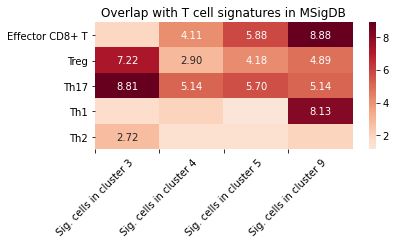

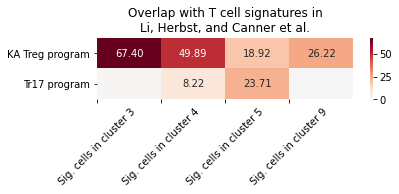

In [12]:
# Overlap with signatures
temp_df = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gs_file/tcell_signature_full.gs', 
                      sep='\t', index_col=0)
df_sig = temp_df.loc[['effector_cd8', 'SUBTYPE_Treg', 'SUBTYPE_Th1', 'SUBTYPE_Th2', 'SUBTYPE_Th17']].copy()
for gs in df_sig.index:
    df_sig.loc[gs, 'GENESET'] = set([DIC_MAP_H2M[x] 
                                     for x in df_sig.loc[gs, 'GENESET'].split(',') if x in DIC_MAP_H2M])

    
temp_df = pd.read_excel('/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gene_annotation'
                        '/Li_CR_2019_tabs2.xlsx', sheet_name='Treg Pagoda modules', skiprows=1)
df_sig.loc['KA_TR_Li', 'GENESET'] = (set(temp_df['Module 12']) | set(temp_df['Module 21'])) - {np.nan}
df_sig.loc['Tr17_Li', 'GENESET'] = set(temp_df['Module 13']) - {np.nan}

# Save Li et al. gene sets
temp_df = df_sig.loc[['KA_TR_Li', 'Tr17_Li']].copy()
temp_df['GENESET'] = [','.join(sorted(x)) for x in temp_df['GENESET']]
temp_df.to_csv(DATA_PATH+'/supp_table/Li_et_al_Treg_program.tsv', sep='\t')

# Compute stats 
background_set = set(adata.var_names)
df_stats = pd.DataFrame(index=df_sig.index, columns=group_list, data=0)
for sig in df_sig.index:
    gs_sig = df_sig.loc[sig, 'GENESET']
    for group in group_list:
        df_gene = sc.get.rank_genes_groups_df(adata, group=group)
        gs = set(df_gene['names'][:300])
        pvalue,oddsratio,or_ub,or_lb = scdrs.util.test_overlap(gs, gs_sig, background_set)
        df_stats.loc[sig, group] = pvalue
#         print('%s    %s    overlap=%d    p=%0.1e    %s'
#               %(sig, group, len(gs & gs_sig), pvalue, ','.join(gs & gs_sig)))
# display(df_stats)

# Make figure: MSigDB signatures 
plot_list = ['effector_cd8', 'SUBTYPE_Treg', 'SUBTYPE_Th17', 'SUBTYPE_Th1', 'SUBTYPE_Th2']
plot_name = ['Effector CD8+ T', 'Treg', 'Th17', 'Th1', 'Th2']
df_plot = -np.log10(df_stats.loc[plot_list].copy())
df_plot.index = plot_name
df_plot.columns = ['Sig. cells in cluster %s'%x.split('.')[0] for x in df_plot.columns]
df_annot = df_plot.copy()
threshold = -np.log10(0.05/df_plot.shape[0]/df_plot.shape[1])
for col in df_annot:
    df_annot[col] = ['%0.2f'%x if x>threshold else '' for x in df_annot[col]]
plt.figure(figsize=[6,3.5])
sns.heatmap(df_plot, annot=df_annot, fmt='s', cmap='RdBu_r', center=0)
plt.xticks(np.arange(df_plot.shape[1]), df_plot.columns, rotation=45)
plt.ylabel('')
plt.title('Overlap with T cell signatures in MSigDB')
plt.tight_layout()
plt.savefig(FIG_PATH+'/sctrs_assoc.IBD_overlap_dsigdb.svg')
plt.show()

# Make figure: Li et al signatures 
plot_list = ['KA_TR_Li', 'Tr17_Li']
plot_name = ['KA Treg program', 'Tr17 program']
df_plot = -np.log10(df_stats.loc[plot_list].copy())
df_plot.index = plot_name
df_plot.columns = ['Sig. cells in cluster %s'%x.split('.')[0] for x in df_plot.columns]
df_annot = df_plot.copy()
threshold = -np.log10(0.05/df_plot.shape[0]/df_plot.shape[1])
for col in df_annot:
    df_annot[col] = ['%0.2f'%x if x>threshold else '' for x in df_annot[col]]
plt.figure(figsize=[6,2.8])
sns.heatmap(df_plot, annot=df_annot, fmt='s', cmap='RdBu_r', center=0)
plt.xticks(np.arange(df_plot.shape[1]), df_plot.columns, rotation=45)
plt.ylabel('')
plt.title('Overlap with T cell signatures in\nLi, Herbst, and Canner et al.')
plt.tight_layout()
plt.savefig(FIG_PATH+'/sctrs_assoc.IBD_overlap_Li.svg')
plt.show()

### Per-cluster analysis for PASS_IBD_deLange2017 associated cells 

In [14]:
# Is the selection in each cluster random?    
group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
df_stats = pd.DataFrame(index=group_list, columns=['C', 'pval'], dtype=float)
df_stats['C'] = [0.78286691, 0.7444599, 0.79507505, 0.8922842]
df_stats['pval'] = [0.000999001, 0.008991009, 0.005994006, 0.075924076]

n_ctrl = 1000 
# ds = 'tms_facs'
# for cluster in group_list: 
#     print(cluster)
#     cluster_leiden = int(cluster.split('.')[0])
#     temp_adata = dic_data_proc[ds][dic_data_proc[ds].obs['leiden_reorder']==cluster_leiden,:].copy()
#     temp_df = dic_ctrl_score[ds][trait].loc[temp_adata.obs_names].copy()
#     c_ = scdrs.method.gearys_c(temp_adata, dic_score[ds].loc[temp_adata.obs_names, '%s.norm_score'%trait])
#     v_c_ctrl = np.zeros(n_ctrl)
#     for i_ctrl in range(n_ctrl):
#         v_c_ctrl[i_ctrl] = scdrs.method.gearys_c(temp_adata, temp_df['ctrl_norm_score_%d'%i_ctrl])
#     df_stats.loc[cluster] = [c_, (np.sum(c_>=v_c_ctrl)+1)/(n_ctrl+1)]

df_stats['pval_str_num'] = [scdrs.util.p_2_str_num(x,n_ctrl) for x in df_stats['pval']]
display(df_stats)

,C,pval,pval_str_num
3.sig,0.782867,0.000999,P<0.001
4.sig,0.744460,0.008991,P=0.009
5.sig,0.795075,0.005994,P=0.006
9.sig,0.892284,0.075924,P=0.076


In [15]:
temp_adata = adata.copy()
temp_adata.obs['leiden_sig_new'] = [x for x in temp_adata.obs['leiden_sig']]
for group in group_list:
    ind_select = (temp_adata.obs['leiden_sig']=='nonsig') & (temp_adata.obs['leiden_reorder']==group.split('.')[0])
    temp_adata.obs.loc[ind_select, 'leiden_sig_new'] = group.replace('sig', 'nonsig')

group_list_new = sorted([x for x in temp_adata.obs['leiden_sig_new'].unique() if ('.sig' in x) | ('.nonsig' in x)])
sc.tl.rank_genes_groups(temp_adata, groupby='leiden_sig_new', groups=group_list_new)
# sc.pl.rank_genes_groups(temp_adata, fontsize=10, ncols=2, n_genes=25)

... storing 'leiden_sig_new' as categorical


In [16]:
# Pathway: enrichr
dic_pathway = {}
pw_list = []
for group in group_list_new:
# for group in ['3.sig']:
    df_gene = sc.get.rank_genes_groups_df(temp_adata, group=group)
    gene_list = list(df_gene['names'][:300])

    res = gp.enrichr(gene_list=gene_list, description='pathway',
                     gene_sets=['KEGG_2019_Mouse', 'GO_Biological_Process_2018', 'Reactome_2016'],
                     organism='Mouse', outdir=None)
    df_pathway = res.results
    df_pathway = df_pathway.loc[df_pathway['Adjusted P-value']<0.01].copy()
    df_pathway['Intersect'] = [int(x.split('/')[0]) for x in df_pathway['Overlap']]
    df_pathway['Term_size'] = [int(x.split('/')[1]) for x in df_pathway['Overlap']]
    df_pathway['Recall'] = df_pathway['Intersect'] / df_pathway['Term_size']
    dic_pathway[group] = df_pathway.copy()
    ind_select = (df_pathway['Intersect']>10) & (df_pathway['Recall']>0.10) & (df_pathway['Term_size']<500) 
    pw_list.extend(df_pathway.loc[ind_select, 'Term'])

for group in group_list_new:
    dic_pathway[group].index = dic_pathway[group]['Term']
    dic_pathway[group] = dic_pathway[group].loc[set(dic_pathway[group].index) & set(pw_list)]

3.sig


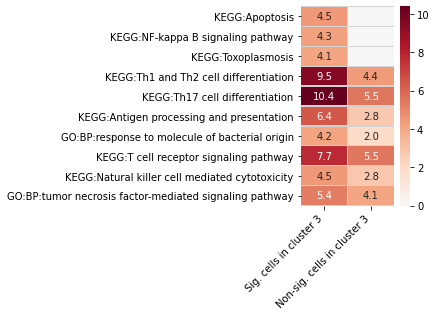

4.sig


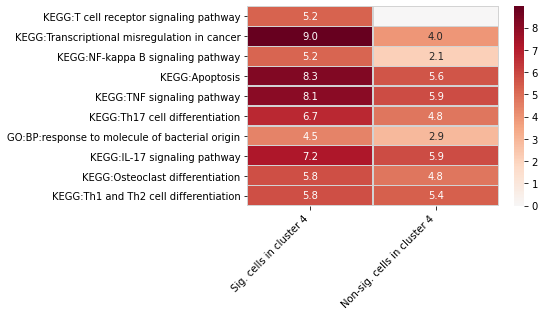

5.sig


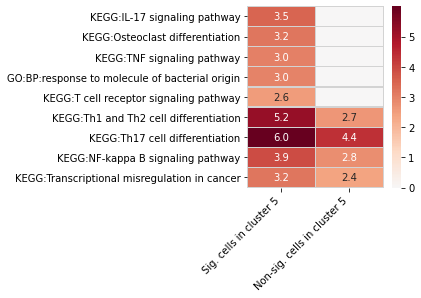

9.sig


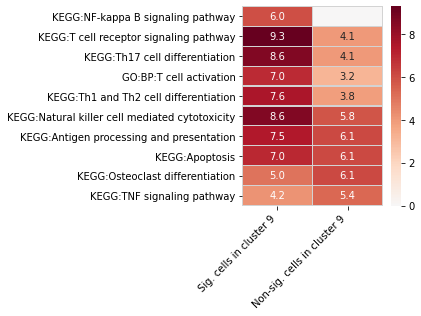

In [17]:
dic_source = {'KEGG_2019_Mouse':'KEGG', 'GO_Biological_Process_2018':'GO:BP', 'Reactome_2016':'REAC'}
for cluster in group_list:
    print(cluster)
    df_plot = pd.DataFrame()
    for group in [cluster, cluster.replace('sig', 'nonsig')]:
        temp_df = dic_pathway[group][['Adjusted P-value']]
        temp_df.index = ['%s:%s'%(dic_source[x],y.split(' (GO')[0].split(' Homo')[0]) 
                         for x,y in zip(dic_pathway[group]['Gene_set'], dic_pathway[group]['Term'])]
        temp_df.columns = [group]
        df_plot = df_plot.join(temp_df, how='outer')

    df_plot.fillna(1, inplace=True)
    df_plot = -np.log10(df_plot)
    df_plot['max'] = df_plot.max(axis=1)
    df_plot['dif'] = df_plot.iloc[:,0] - df_plot.iloc[:,1]+10*(df_plot.iloc[:,1]==0)
    df_plot = df_plot.sort_values(by='max', ascending=False, inplace=False).iloc[:10]
    df_plot.sort_values(by='dif', ascending=False, inplace=True)
    df_plot.index.name = ''
    df_plot = df_plot[[cluster, cluster.replace('sig', 'nonsig')]]
    df_plot.columns = ['Sig. cells in cluster %s'%cluster.split('.')[0],
                       'Non-sig. cells in cluster %s'%cluster.split('.')[0],]
    df_annot = df_plot.copy()
    for col in df_annot.columns:
        df_annot[col] = ['%0.1f'%x if x>0.1 else '' for x in df_annot[col]]
    
    if df_plot.shape[0]==0:
        continue
    plt.figure(figsize=[6+2*(cluster=='4.sig'), 2+0.25*df_plot.shape[0]])
    sns.heatmap(df_plot, cmap='RdBu_r', annot=df_annot, fmt='s', center=0, linewidths=0.2, linecolor='lightgrey')
    plt.xticks(np.arange(df_plot.shape[1])+0.5, df_plot.columns, rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/IBD_pathway.nonsig.%s.svg'%cluster)
    plt.show()

### CD4/CD8 effector gradients

dpt_cd4_qn n_cell=1686, clusters=1,2,3,4


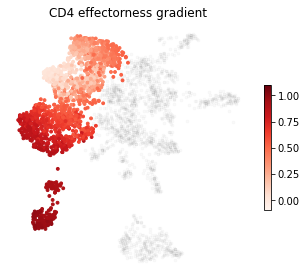

dpt_cd8_qn n_cell=2197, clusters=1,2,7,8,9


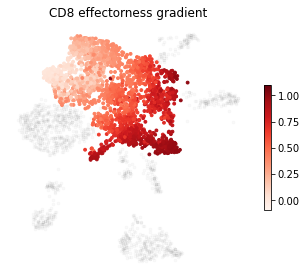

In [18]:
# Pseudotime: make it nicer later 
ds='tms_facs'
adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
dic_title = {'dpt_cd4_qn': 'CD4 effectorness gradient', 'facs_cd4': 'CD4 effectorness gradient',
             'dpt_cd8_qn': 'CD8 effectorness gradient', 'facs_cd8': 'CD8 effectorness gradient'}
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs[['dpt_cd4_qn', 'dpt_cd8_qn', 'leiden_reorder']])

for term in ['dpt_cd4_qn', 'dpt_cd8_qn']:    
    plt.figure(figsize=[4.5,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    ind_select = df_plot[term]>=0
    print('%s n_cell=%d, clusters=%s'%(term, ind_select.sum(), 
                                       ','.join([str(x) for x in sorted(set(df_plot.loc[ind_select,
                                                                                        'leiden_reorder']))])))
    plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                c='k', alpha=0.025, s=8)
    plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                c=df_plot.loc[ind_select, term], cmap='Reds', vmax=1.1, vmin=-0.1, s=8)
    plt.colorbar(shrink=0.5)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title(dic_title[term])
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/%s.svg'%term)
    plt.show()

In [19]:
# Prepare regression datasets 
n_ctrl = 1000 
dic_cov = {}

# FACS CD4 
dic_cov['facs_cd4'] = dic_data_proc['tms_facs'].obs.copy()
dic_cov['facs_cd4']['effectorness'] = dic_cov['facs_cd4']['dpt_cd4_qn']
dic_cov['facs_cd4'] = dic_cov['facs_cd4'].loc[dic_cov['facs_cd4']['effectorness']>0].copy()

# FACS CD8 
dic_cov['facs_cd8'] = dic_data_proc['tms_facs'].obs.copy()
dic_cov['facs_cd8']['effectorness'] = dic_cov['facs_cd8']['dpt_cd8_qn']
dic_cov['facs_cd8'] = dic_cov['facs_cd8'].loc[dic_cov['facs_cd8']['effectorness']>0].copy()

# Add const and leiden
for cov_name in dic_cov:
    dic_cov[cov_name]['const'] = 1
    for cluster in set(dic_cov[cov_name]['leiden_reorder']):
        if (dic_cov[cov_name]['leiden_reorder']==cluster).sum()>0:
            dic_cov[cov_name]['leidenreg_%d'%cluster] = (dic_cov[cov_name]['leiden_reorder']==cluster)*1

In [20]:
# Regression analysis
dic_reg = {'reg_marginal': ['effectorness'],
           'reg_joint': ['effectorness', 'leidenreg']
          }

dic_stats = {}
for cov_name in dic_cov:
    for reg_name in dic_reg:
        print(cov_name, reg_name)
        reg_list = dic_reg[reg_name].copy()
        if 'leidenreg' in reg_list:
            reg_list.remove('leidenreg')
            ctrl_list = ['const'] + [x for x in dic_cov[cov_name].columns if 'leidenreg' in x]
        else:
            ctrl_list = ['const']
        df_stats = pd.DataFrame(columns=['var_ctrl','var']+['%s.%s'%(y,x) for x in reg_list for y in ['T', 'P']])
        ds = cov_name.split('_' )[0]
        
        for score in ['tms_facs', 'tms_facs.tsig']:
            for trait in DIC_TRAIT_LIST[score]:
                if '%s.norm_score'%trait not in dic_score[score]:
                    print('Missing', score, '%s.norm_score'%trait)
                    continue              

                df_reg = dic_cov[cov_name][reg_list+ctrl_list].copy()
                df_reg = df_reg.join(dic_score[score][['%s.norm_score'%trait]])
                df_reg = df_reg.join(dic_ctrl_score[score][trait])
                
                res = sm.OLS(df_reg['%s.norm_score'%trait], df_reg[ctrl_list]).fit()
                var_explain_ctrl_ = 1 - res.mse_resid/res.mse_total

                res = sm.OLS(df_reg['%s.norm_score'%trait], df_reg[ctrl_list+reg_list]).fit()
                var_explain_ = 1 - res.mse_resid/res.mse_total
                dic_t = {x:res.tvalues[x] for x in reg_list}
                dic_t_ctrl = {x:np.zeros(n_ctrl) for x in reg_list}

                for i in range(n_ctrl):
                    res = sm.OLS(df_reg['ctrl_norm_score_%d'%i], df_reg[ctrl_list+reg_list]).fit()
                    for reg in reg_list:
                        dic_t_ctrl[reg][i] = res.tvalues[reg]
                if trait in ['naive_cd4', 'naive_cd8']:
                    dic_p = {x:((dic_t[x] >= dic_t_ctrl[x]).sum()+1) / (n_ctrl+1) for x in reg_list} 
                else:
                    dic_p = {x:((dic_t[x] <= dic_t_ctrl[x]).sum()+1) / (n_ctrl+1) for x in reg_list} 
                df_stats.loc[trait] = [var_explain_ctrl_, var_explain_] + \
                    [y[x] for x in reg_list for y in [dic_t, dic_p]]

        for reg_term in reg_list:
            df_stats['P_STR.%s'%reg_term] = [scdrs.util.p_2_str(x) for x in df_stats['P.%s'%reg_term]]
            df_stats['P_STR_NUM.%s'%reg_term] = [scdrs.util.p_2_str_num(x,n_ctrl) for x in df_stats['P.%s'%reg_term]]
        dic_stats['%s.%s'%(cov_name, reg_name)] = df_stats

facs_cd4 reg_marginal
facs_cd4 reg_joint
facs_cd8 reg_marginal
facs_cd8 reg_joint


In [21]:
# Output table: Association p-values
trait_list = DIC_TRAIT_LIST['tms_facs'].copy()
df_res = pd.DataFrame(index=trait_list)
df_res['Trait'] = [DF_TRAIT_INFO.loc[x, 'Code'] for x in df_res.index]

for cov_name in dic_cov:
    term = 'CD4' if cov_name=='facs_cd4' else 'CD8'
    # Marginal regression
    temp_df = dic_stats['%s.reg_marginal'%(cov_name)][['P.effectorness', 'var']].copy()
    temp_df.columns = ['%s.P'%term, '%s.Var'%term]
    df_res = df_res.join(temp_df)
    
    # Joint regression 
    temp_df = dic_stats['%s.reg_joint'%(cov_name)][['var_ctrl', 'var', 'P.effectorness']]
    temp_df.columns = ['%s.Var.cluster'%term, '%s.Var.joint'%term, '%s.P.joint'%term]
    df_res = df_res.join(temp_df)
    
df_res = df_res[['Trait', 'CD4.P', 'CD4.Var', 'CD4.P.joint', 'CD8.P', 'CD8.Var', 'CD8.P.joint', ]]
for col in ['CD4.P', 'CD4.P.joint', 'CD8.P', 'CD8.P.joint']:
    df_res[col] = ['$\textbf{%0.3f}$'%x if x<0.005 else '$%0.3f$'%x for x in df_res[col]]
for col in ['CD4.Var', 'CD8.Var']:
    df_res[col] = ['%0.3f'%x for x in df_res[col]]
print(df_res.to_latex(index=False, escape=False, column_format='|c|cc|c|cc|c|'))

\begin{tabular}{|c|cc|c|cc|c|}
\toprule
  Trait &             CD4.P & CD4.Var &       CD4.P.joint &    CD8.P & CD8.Var & CD8.P.joint \\
\midrule
    IBD &  $\textbf{0.001}$ &   0.282 &  $\textbf{0.005}$ &  $0.021$ &   0.083 &     $0.021$ \\
     CD &  $\textbf{0.001}$ &   0.202 &  $\textbf{0.004}$ &  $0.026$ &   0.087 &     $0.006$ \\
     UC &  $\textbf{0.004}$ &   0.159 &           $0.067$ &  $0.441$ &  -0.000 &     $0.548$ \\
     RA &           $0.118$ &   0.024 &           $0.268$ &  $0.261$ &   0.006 &     $0.569$ \\
     MS &           $0.223$ &   0.009 &           $0.238$ &  $0.129$ &   0.020 &     $0.418$ \\
    AIT &  $\textbf{0.002}$ &   0.188 &           $0.007$ &  $0.038$ &   0.064 &     $0.194$ \\
     HT &  $\textbf{0.003}$ &   0.153 &           $0.030$ &  $0.100$ &   0.028 &     $0.267$ \\
 Eczema &           $0.011$ &   0.087 &           $0.250$ &  $0.819$ &   0.016 &     $0.888$ \\
    ASM &           $0.035$ &   0.059 &           $0.387$ &  $0.325$ &   0.001 &     $0

facs_cd4 ['naive_cd4', 'memory_cd4', 'effector_cd4'] (1685, 33)


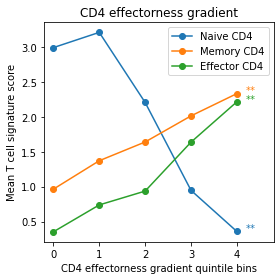

facs_cd8 ['naive_cd8', 'memory_cd8', 'effector_cd8'] (2196, 34)


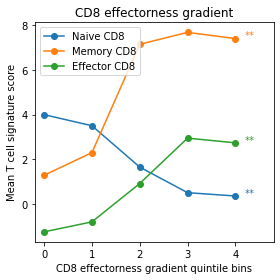

In [22]:
# T cell signatures
score = 'tms_facs.tsig'
plot_list = [['facs_cd4', ['naive_cd4', 'memory_cd4', 'effector_cd4']],
             ['facs_cd8', ['naive_cd8', 'memory_cd8', 'effector_cd8']] ]

for cov_name,trait_list in plot_list:
    df_plot = dic_cov[cov_name].copy()
    df_plot = df_plot.join(dic_score[score][['%s.norm_score'%x for x in trait_list]])
    df_plot['bin'] = pd.qcut(df_plot['effectorness'], q=5, labels=False)
    print(cov_name, trait_list, df_plot.shape)
    
    plt.figure(figsize=[4,4])
    i_color = 0
    for trait in trait_list:
        temp_df = df_plot.groupby('bin').agg({'%s.norm_score'%trait: np.mean})
        plt.plot(temp_df.index, temp_df['%s.norm_score'%trait], 'o-', 
                 label=DF_TRAIT_INFO.loc[trait, 'Code'], color='C%d'%i_color)
        plt.text(4.2, temp_df['%s.norm_score'%trait][4], 
                 dic_stats['%s.reg_marginal'%cov_name].loc[trait,'P_STR.effectorness'],
                 color='C%d'%i_color)
        i_color+=1    
    plt.xlim([-0.2,4.8])
    plt.legend()
    plt.xlabel('%s quintile bins'%dic_title[cov_name])
    plt.ylabel('Mean T cell signature score')
    plt.title(dic_title[cov_name])
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/dpt_tsig_corr.%s.svg'%cov_name)
    plt.show()
    

facs_cd4 ['UKB_460K.disease_AID_ALL', 'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP', 'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED', 'UKB_460K.disease_ASTHMA_DIAGNOSED', 'PASS_IBD_deLange2017', 'UKB_460K.body_HEIGHTz'] (1685, 36)


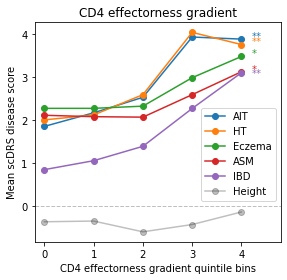

facs_cd8 ['UKB_460K.disease_AID_ALL', 'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP', 'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED', 'UKB_460K.disease_ASTHMA_DIAGNOSED', 'PASS_IBD_deLange2017', 'UKB_460K.body_HEIGHTz'] (2196, 37)


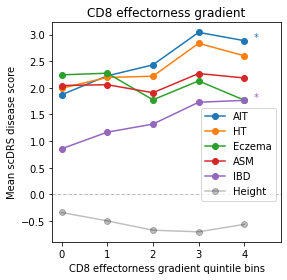

In [23]:
# Traits
score = 'tms_facs'
trait_list = ['UKB_460K.disease_AID_ALL',
              'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP',
              'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED', 
              'UKB_460K.disease_ASTHMA_DIAGNOSED',
              'PASS_IBD_deLange2017',  
              'UKB_460K.body_HEIGHTz'
             ]

for cov_name in ['facs_cd4', 'facs_cd8']:
    df_plot = dic_cov[cov_name].copy()
    df_plot = df_plot.join(dic_score[score][['%s.norm_score'%x for x in trait_list]])
    df_plot['bin'] = pd.qcut(df_plot['effectorness'], q=5, labels=False)
    print(cov_name, trait_list, df_plot.shape)
    
    plt.figure(figsize=[4.1,4])
    i_color = 0
    y_text = 5
    for trait in trait_list:
        alpha_=0.25 if trait=='UKB_460K.body_HEIGHTz' else 1
        color_='k' if trait=='UKB_460K.body_HEIGHTz' else 'C%d'%i_color
        temp_df = df_plot.groupby('bin').agg({'%s.norm_score'%trait: np.mean})
        plt.plot(temp_df.index, temp_df['%s.norm_score'%trait], 'o-', 
                 label=DF_TRAIT_INFO.loc[trait, 'Code'], color=color_, alpha=alpha_)
        if cov_name=='facs_cd4':
            y_text = min(y_text-0.1, temp_df['%s.norm_score'%trait][4])
        else:
            y_text = temp_df['%s.norm_score'%trait][4]
        plt.text(4.2, y_text, dic_stats['%s.reg_marginal'%cov_name].loc[trait,'P_STR.effectorness'], 
                 color=color_, alpha=alpha_)
        i_color+=1
    plt.axhline(y=0, ls="--", color="k", lw=1, alpha=0.25)
    plt.xlim([-0.2,4.8])
    plt.legend(loc='center right', bbox_to_anchor=[1,0.4])
    plt.xlabel('%s quintile bins'%dic_title[cov_name])
    plt.ylabel('Mean scDRS disease score')
    plt.title(dic_title[cov_name])
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/dpt_trait_corr.%s.svg'%cov_name)
    plt.show()
#     break